In [1]:
library(repr); options(repr.plot.res = 100, repr.plot.width = 6, repr.plot.height = 6) # Change plot sizes (in cm) - this bit of code 6s only relevant i6 you are using a jupyter notebook - ignore otherwise

# Linear Models: regression

```{admonition} Learning goals
**By the end of this chapter you should be able to:**
- Fit simple linear regression models in R using `lm()` and interpret output
- Extract and interpret model coefficients, standard errors, $R^2$, and p-values
- Generate predictions with confidence and prediction intervals
- Check model assumptions using residual diagnostic plots (Q-Q, residuals vs fitted, scale-location)
- Identify influential points and outliers using Cook's distance and leverage
- Communicate regression findings with publication-quality figures and concise text
```

```{admonition} Prerequisites
:class: tip
**Before starting this chapter, you should:**
- Have covered basic hypothesis testing vocabulary (p-values, confidence intervals, null hypotheses) from [t-tests](t-f-tests)
- Be proficient with plotting and data summarisation skills in R
- Understand the difference between correlation and causation
```

## Introduction

Linear regression is a class of [Linear Models](https://en.wikipedia.org/wiki/Linear_model) that is frequently a good choice if both, your response (dependent) and your predictor (independent) variables are continuous. In this Chapter you will learn:

* To *explore* your data in order to determine whether a Linear Model is a good choice by
    * Visualizing your data (in R)
    * Calculating correlations between variables

* To *fit* a Linear regression Model to data

* To determine whether the Model adequately fits your data (its "significance"), and also whether is it is at all an appropriate model for those data, by
    * Plotting the data and the fitted Model together
    * Calculating goodness of fit measures and statistics
    * Using diagnostic plots

    "It is expected that you have already been introduced to, or are familiar with the concepts (and/or theory) underlying Linear Models. If not, you may want to see the [Linear Models lecture](https://github.com/MulQuaBio/MQB/tree/main/content/lectures/linearmodels) (you can also watch the [video](https://drive.google.com/drive/folders/12Sj56wHX6vcAnp9GE9qQ1gIXbn7QrHU2?usp=sharing)).\n",

As with the previous chapters, we'll start with creating a new blank script for you to fill in during the practical (the script file `regress.R` is also available from [MQB repository](https://github.com/MulQuaBio/MQB/tree/main/content/code)). 

We will use the genome size data (from the [previous chapter](./t-f-tests.ipynb)) again. So,

&starf; Open r and `setwd` to your `code` directory.

&starf; Create a new blank script called `regression.R` and add some introductory comments.

&starf; Add code to your script to load the genome size data into r and check it (again, using the relative path prefix `../`, assuming that you working directory is `code`):

In [2]:
genome <- read.csv('../data/genome_size.csv', stringsAsFactors = TRUE)

# Normalize expected column names (the dataset header has changed over time)
if ("GenomeSize" %in% names(genome) && !("genome_size" %in% names(genome))) {
  names(genome)[names(genome) == "GenomeSize"] <- "genome_size"
}

# Ensure the key columns used below are numeric (avoid factors/characters breaking cor.test/log())
genome$genome_size <- as.numeric(as.character(genome$genome_size))
genome$TotalLength <- as.numeric(as.character(genome$TotalLength))
genome$BodyWeight <- as.numeric(as.character(genome$BodyWeight))

head(genome)


,Suborder,Family,Species,genome_size,GenomeSE,GenomeN,BodyWeight,TotalLength,HeadLength,ThoraxLength,AdbdomenLength,ForewingLength,HindwingLength,ForewingArea,HindwingArea,MorphologyN
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,Anisoptera,Aeshnidae,Aeshna canadensis,2.20,NA,1,0.159,67.58,6.83,11.81,48.94,45.47,45.40,369.57,483.61,2
2,Anisoptera,Aeshnidae,Aeshna constricta,1.76,0.06,4,0.228,71.97,6.84,10.72,54.41,46.00,45.48,411.15,517.38,3
3,Anisoptera,Aeshnidae,Aeshna eremita,1.85,NA,1,0.312,78.80,6.27,16.19,56.33,51.24,49.47,460.72,574.33,1
4,Anisoptera,Aeshnidae,Aeshna tuberculifera,1.78,0.10,2,0.218,72.44,6.62,12.53,53.29,49.84,48.82,468.74,591.42,2
5,Anisoptera,Aeshnidae,Aeshna umbrosa,2.00,NA,1,0.207,73.05,4.92,11.11,57.03,46.51,45.97,382.48,481.44,1
6,Anisoptera,Aeshnidae,Aeshna verticalis,1.59,NA,1,0.220,66.25,6.48,11.64,48.13,45.91,44.91,400.40,486.97,1


Exploring the data
------------------

In previous chapters we used `plot` to create a scatterplot between two variables. If you have a set of variables to explore, writing code for each plot is tiresome, so r provides a function `pairs`, which creates a grid of scatter plots between each pair of variables. All it needs is a dataset.

First, plot all pairs:

In [3]:
library(repr); options(repr.plot.res = 100, repr.plot.width = 10, repr.plot.height = 10)

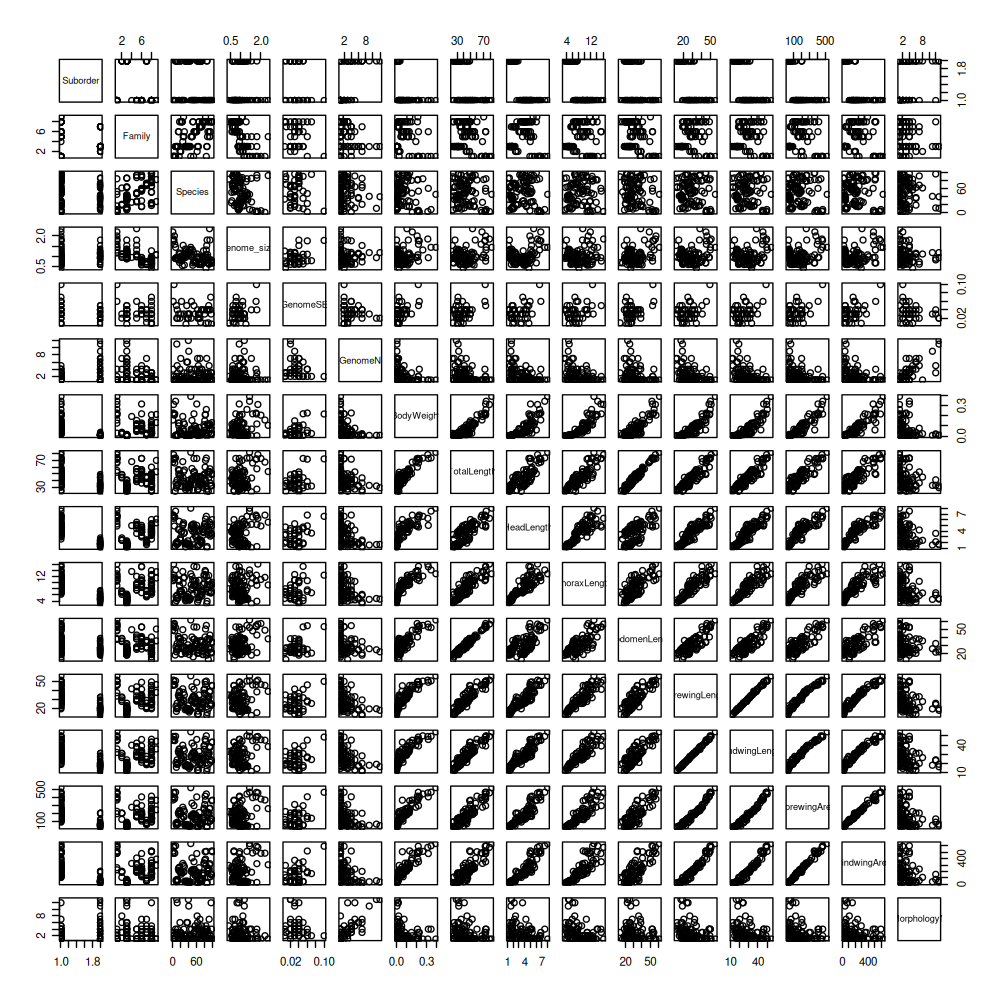

In [4]:
pairs(genome)

That's messy! There are too many columns that we are plotting against each other, so its hard to get a meaningful picture (literally). So let's try color-coding the scatterplot markers by suborder:  

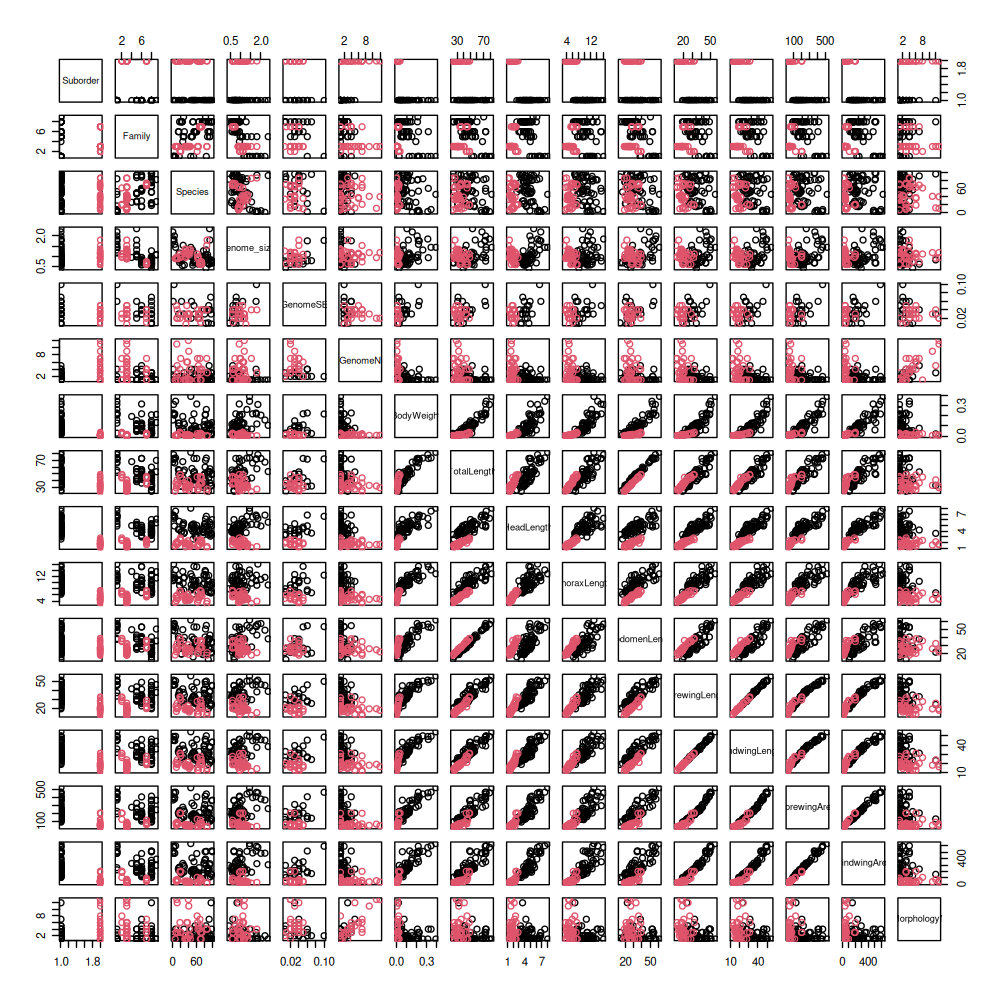

In [5]:
pairs(genome, col=genome$Suborder)

The result is still too messy! There are far too many variables in `genome` for this to be useful. Before we proceed further,

&starf; Add `pairs(genome, col=genome$Suborder)` into your script and run the code:

So, we need to cut down the data to fewer variables. [Previously](exp-design.ipynb#explore-further-by-scatter-plotting-two-variables) we used [indices](r-indices) to select colours; here, we can use indices to select columns from the data frame. This again uses square brackets (`x[]`), but a data frame has two dimensions, rows and columns, so you need to provide an index for each dimension, separated by commas. If an index is left blank, then all of that dimension (i.e. all rows or columns) are selected. 

Try the following to re-acquaint yourself to access data frame content using indices:

In [6]:
library(repr); options(repr.plot.res = 100, repr.plot.width = 8, repr.plot.height = 8) # change plot size

In [7]:
# create a small data frame:
dat <- data.frame(A = c("a", "b", "c", "d", "e"), B = c(1, 2, 3, 4, 5))
dat[1, ] # select row 1 (all columns selected)

,A,B
,<chr>,<dbl>
1,a,1


In [8]:
dat[, 2] # select column 2 (all rows selected)

[1] 1 2 3 4 5

In [9]:
dat[2, 1] # select row 2, column 1

[1] "b"

Now let's get resume the actual analysis. We will look at five key variables: genome size, body weight, total length, forewing length and forewing area. If you look at the output of `str(genome)`, you'll see that these are in columns 4, 7, 8, 12 and 14. We can record the indices of these columns and use this to select the data in the pairs plot:

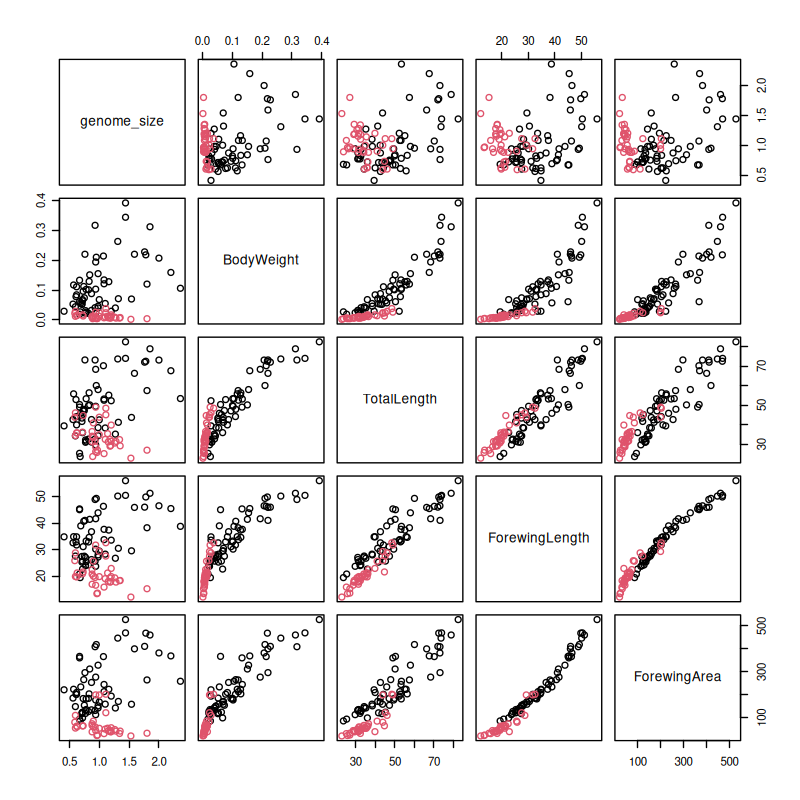

In [10]:
morpho_vars <- c(4, 7, 8, 12, 14) # store the indices
pairs(genome[, morpho_vars], col = genome$Suborder)

&starf; Add the code above to your script and run it.

In the figure above, each scatterplot is shown twice, with the variables swapping between the $x$ and $y$ axes. You can see immediately that the relationships between the four morphological measurements and genome size are fairly scattered but that the plots comparing morphology show much clearer relationships.

(regress:correlations)=
## Correlations

One way of summarising how strong the pair-wise relationship between any two variables is to calculate a *correlation coefficient* between them. 

The Pearson correlation coefficient is the most commonly-used measure. It quantifies the *linear* correlation between two variables as the average of the product of the standardized values of the two variables (let's call them $x$ and $y$):

$$r_{xy}={\frac{\sum _{i=1}^{n}\left({\frac {x_{i}-{\bar {x}}}{s_{x}}}\right)\left({\frac {y_{i}-{\bar {y}}}{s_{y}}}\right)}{n-1}}$$

Here,

* $r_{xy}$ is the correlation coefficient between the variables $x$ and $y$  

* $n$ is sample size

* $x_i, y_i$ are the individual sample points indexed with $i$ ($i = 1,2,\ldots, n$)

*  $\bar{x} = \frac{\sum_{i=1}^n x_i}{n} $ is the the sample mean (same as we learned [before](exp_design:Descriptive-statistics-in-r) and analogous calculation for $\bar{y}$)

* $ s_x = \sqrt{ {\frac{\sum_{i=1}^n(x_i - \bar{x})^2}{n-1}}}$ (sample standard deviation, again same as we learned [before](exp_design:Descriptive-statistics-in-r))

* The quantities $\left({\frac {x_{i}-{\bar {x}}}{s_{x}}}\right)$ and $\left(\frac{y_i-\bar{y}}{s_y} \right)$ are the Z-scores (aka *standard scores*) of $x$ and $y$. This conversion of the raw scores ($x_i$'s and $y_i$'s) to Z-scores is called standardizing (or sometimes, normalizing).

```{note}
The Pearson correlation coefficient is a *parametric* statistic because it requires the *mean* of each variable, which is an [*estimated parameter*](exp_design:Some-statistical-parlance).
```

The calculation of the Pearson correlation coefficient is illustrated in {numref}`Pearson-c-c`.

---
:::{figure-md} Pearson-c-c

<img src="./graphics/corr.svg" alt="Pearson's Correlation Coefficient" width="800px">

**Illustration of what the Pearson correlation coefficient means.** It is calculated using the differences from the mean on each axis. The key calculation is &mdash;for each point&mdash; to get the product of the differences on each axis and add them up. The Pearson correlation coefficient simply scales these sums of $xy$ to be between -1 (perfectly negatively correlated) and 1 (perfectly positively correlated) via zero (no correlation). If the points are mostly top left ($-x$, $y$) or bottom right ($x$, $-y$) then these products are mostly negative ($-xy$); if the points are mostly top right ($x$, $y$) or bottom left ($-x$, $-y$) then the products are mostly positive ($xy$).
:::

---

The plots in in {numref}`Pearson-c-c` show three clear cases where all the values of $xy$ are negative or positive or where both are present and sum to zero. Thus the coefficient ($r_{xy}$) will be positive (negative) if the $x_i$ and $y_i$'s tend to move in the same (opposite) direction relative to their respective means (as illustrated here). 
 
```{note}
More technically, the Pearson correlation coefficient is a normalised measure of the *covariance* (such that it always takes a value between -1 and 1).
```

### Correlations in R

In r, we will use two functions to look at correlations. The first is `cor`, which can calculate correlations between pairs of variables, so is a good partner for `pairs` plots. The second is `cor.test`, which can only compare a single pair of variables, but uses a $t$ test to assess whether the correlation is significant.

$\star$ Try the following (and include it in your r script file):

In [11]:
cor(genome[, morpho_vars], use = "pairwise")

,genome_size,BodyWeight,TotalLength,ForewingLength,ForewingArea
genome_size,1.0000000,0.3430934,0.3407077,0.2544432,0.3107247
BodyWeight,0.3430934,1.0000000,0.9167995,0.8944228,0.9198821
TotalLength,0.3407077,0.9167995,1.0000000,0.9225974,0.9077555
ForewingLength,0.2544432,0.8944228,0.9225974,1.0000000,0.9829803
ForewingArea,0.3107247,0.9198821,0.9077555,0.9829803,1.0000000


This is the correlation matrix. Then:

In [12]:
cor.test(genome$genome_size, genome$TotalLength, use = "pairwise")


	Pearson's product-moment correlation

data:  genome$genome_size and genome$TotalLength
t = 3.5507, df = 96, p-value = 0.0005972
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1526035 0.5049895
sample estimates:
      cor 
0.3407077 


The `use='pairwise'` tells r to omit observations with missing data and use complete pairs of observations. The first function confirms our impressions from the graphs: the correlations between genome size and morphology are positive but comparatively weak and the correlations between morphological measurements are positive and very strong (i.e. close to 1). The correlation test tells us that genome size and body length are positively correlated (r=0.34, $t$ = 3.5507, df = 96, $p$ = 0.0006). 

*remember this example when reporting correlations in your reports &ndash; all this information needs to be included*

Also, in case you are wondering about what the t-value in the `cor.test` signifies:    

The t-test is used within `cor.test` to establish if the correlation coefficient is significantly different from zero, that is, to test if there is a significant association between the two variables. If you recall from the previous Chapter, the t-test, in general, can be used to test if the mean of a sample is significantly different from some reference value (1-sample t-test). Here, the "mean of the sample" is the observed correlation coefficient, and the reference value is 0 (the null hypothesis, that there is no association).

## Transformations and allometric scaling

There is one problem with the correlations above: *the correlation coefficient calculation assumes a straight line relationship* (a linear correlation). Some of the scatterplots above are fairly straight but there are some strongly curved relationships. This is due to [allometric scaling](https://en.wikipedia.org/wiki/Allometry), where one body measure changes (or grows) disproportionately with respect to another. Here, two of the variables are in linear units (total and forewing length), one is in squared units (forewing area) and one in cubic units (body weight, which is approximately volume). That these measures are in different units itself guarantees that they will scale allometrically with respect to each other. 

The relationships between these variables can be described using a power law: 

$$y = ax^b$$

Fortunately, if we log transform this equation, we get $\log(y) = \log(a) + b \log(x)$. This is the equation of a straight line ($y=a+bx$), so we should be able to make these plots straighter by logging both axes. We saw [previously](t-f-tests.ipynb#t-tests-revisited) that we can create a new logged variable in the data frame like this:

In [13]:
genome$logGS <- log(genome$genome_size)

&starf; Using this command as a template, create a new logged version of the five
variables listed above:

In [14]:
genome$logGS <- log(genome$genome_size)
genome$logBW <- log(genome$BodyWeight)
genome$logTL <- log(genome$TotalLength)
genome$logFL <- log(genome$ForewingLength)
genome$logFA <- log(genome$ForewingArea)

&starf; Then, using `str`, work out which column numbers the logged variables are and create a new variable called `logmorpho` containing these numbers:

In [15]:
str(genome)

'data.frame':	100 obs. of  21 variables:
 $ Suborder      : Factor w/ 2 levels "Anisoptera","Zygoptera": 1 1 1 1 1 1 1 1 1 1 ...
 $ Family        : Factor w/ 9 levels "Aeshnidae","Calopterygidae",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Species       : Factor w/ 100 levels "Aeshna canadensis",..: 1 2 3 4 5 6 8 17 46 53 ...
 $ genome_size   : num  2.2 1.76 1.85 1.78 2 1.59 1.44 1.16 1.44 1.2 ...
 $ GenomeSE      : num  NA 0.06 NA 0.1 NA NA NA NA NA NA ...
 $ GenomeN       : int  1 4 1 2 1 1 1 1 1 1 ...
 $ BodyWeight    : num  0.159 0.228 0.312 0.218 0.207 0.22 0.344 0.128 0.392 0.029 ...
 $ TotalLength   : num  67.6 72 78.8 72.4 73 ...
 $ HeadLength    : num  6.83 6.84 6.27 6.62 4.92 6.48 7.53 5.74 8.05 5.28 ...
 $ ThoraxLength  : num  11.8 10.7 16.2 12.5 11.1 ...
 $ AdbdomenLength: num  48.9 54.4 56.3 53.3 57 ...
 $ ForewingLength: num  45.5 46 51.2 49.8 46.5 ...
 $ HindwingLength: num  45.4 45.5 49.5 48.8 46 ...
 $ ForewingArea  : num  370 411 461 469 382 ...
 $ HindwingArea  : num  484 517 574

In [16]:
logmorpho <- c(17,18,19,20,21)

We can now use the `pairs` and `cor` test as before for the columns in `logmorpho`:

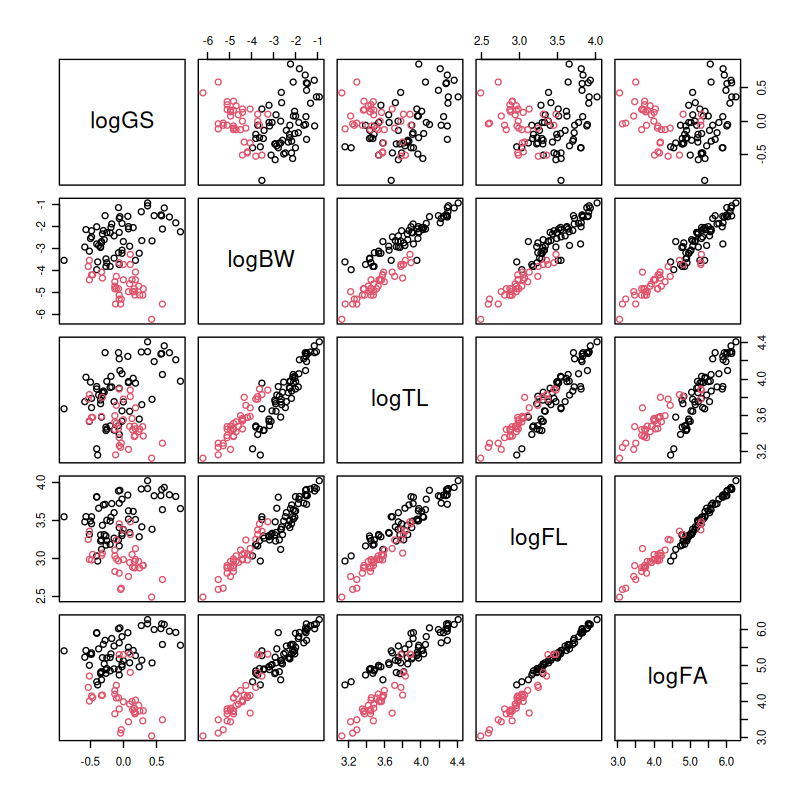

In [17]:
pairs(genome[, logmorpho], col=genome$Suborder)

In [18]:
cor(genome[, logmorpho], use='pairwise')

,logGS,logBW,logTL,logFL,logFA
logGS,1.00000000,0.08406293,0.2224443,0.1150025,0.06808306
logBW,0.08406293,1.00000000,0.8891899,0.9456492,0.94995683
logTL,0.22244431,0.88918989,1.0000000,0.9157695,0.86207098
logFL,0.11500250,0.94564919,0.9157695,1.0000000,0.97916470
logFA,0.06808306,0.94995683,0.8620710,0.9791647,1.00000000


The scatterplots show that logging the data has very successfully addressed curvature (non-linearity) due to allometric scaling between variables in the data.

(regress:perform)=
## Performing the regression analysis

We'll now look at fitting the first linear model of this course, to explore whether log genome size explains log body weight. The first thing to do is to plot the data (as you did [previously](exp-design.ipynb#explore-further-by-scatter-plotting-two-variables)):

In [19]:
myColours <- c('red', 'blue') # Choose two colours
mySymbols <- c(1,3) # And two different markers
colnames(genome)

[1] "Suborder"       "Family"         "Species"        "genome_size"   
 [5] "GenomeSE"       "GenomeN"        "BodyWeight"     "TotalLength"   
 [9] "HeadLength"     "ThoraxLength"   "AdbdomenLength" "ForewingLength"
[13] "HindwingLength" "ForewingArea"   "HindwingArea"   "MorphologyN"   
[17] "logGS"          "logBW"          "logTL"          "logFL"         
[21] "logFA"

In [20]:
library(repr); options(repr.plot.res = 100, repr.plot.width = 6, repr.plot.height = 6) # change plot size

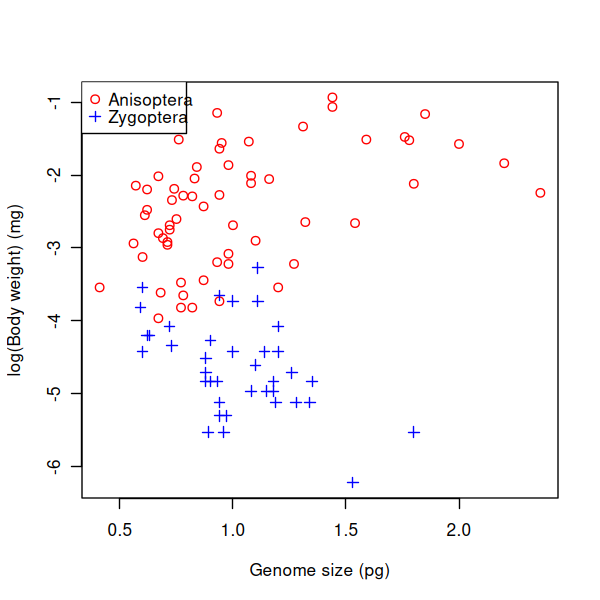

In [21]:
plot(logBW ~ genome_size , data = genome, #Now plot again
col = myColours[Suborder], pch = mySymbols[Suborder],
xlab='Genome size (pg)', ylab='log(Body weight) (mg)')

legend("topleft", legend=levels(genome$Suborder), #Add legend at top left corner
       col= myColours, pch = mySymbols)

It is clear that the two suborders have very different relationships: to begin with we will look at dragonflies (Anisoptera). 

### Fitting the model

We will fit the **the linear (regression) model** 

$y= \beta_1 + \beta_{2}x$,

i.e., a straight line relationship between the response variable and a continuous explanatory variable.

The code below fits this model:

In [22]:
genomeSizeModelDragon <- lm(logBW ~ logGS, data = genome, subset =  Suborder == "Anisoptera")

&starf; Add this model fitting command into your script and run it.

```{tip}
Note the long name (`nullModelDragon`) we used for the model. Short names are easier to type but calling r objects names like `mod1`, `mod2`, ` xxx` swiftly get confusing, so try and keep model names as explicit as possible.
```
Now we want to look at the output of the model. remember from the lecture that a model has *coefficients* (the $\beta$ values in the equation of the model) and *terms* which are the explanatory variables in the model. We'll look at the *coefficients* first:

In [23]:
coef(genomeSizeModelDragon) 

(Intercept)       logGS 
  -2.399471    1.005220

But we need more information to assess the *goodness-of-fit* of this model. So let's this info by using the `summary()` function: 

In [24]:
summary(genomeSizeModelDragon) 


Call:
lm(formula = logBW ~ logGS, data = genome, subset = Suborder == 
    "Anisoptera")

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3243 -0.6124  0.0970  0.5194  1.3236 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.39947    0.09085 -26.413  < 2e-16 ***
logGS        1.00522    0.23975   4.193 9.54e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6966 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.2326,	Adjusted R-squared:  0.2194 
F-statistic: 17.58 on 1 and 58 DF,  p-value: 9.539e-05


There is a lot of information there: the model description ("`Call`"), a summary of the residuals, a table of coefficients and then information on residual standard error, r$^2$, and a $F$ test.

All of these will become clearer during this course (in particular, the meaning of Adjusted r-square will be explained in the [anova chapter](anova.ipynb)) — for the moment, concentrate on the coefficients table:

* There are two rows in the coefficient table, one for each coefficient in $y=\beta_1 + \beta_2x$ — these are the intercept and the slope of the line. The rest the details on each row are a $t$-test of whether the slope and intercept are significantly different from zero.
    * The (least-squares) estimate of the slope coefficient (`logGS`) is equal to the correlation coefficient between the dependent variable ($y$, here `logBW`) and the independent variable ($x$, here `logGS`) times the ratio of the (sample) standard deviations of the two (see [above](#correlations) for the definitions of these):
\begin{equation*} 
    \text{Slope} = \beta_2 = r_{xy} \frac{s_y}{s_x}
\end{equation*}
Thus you can see that the regression slope is proportional to the correlation coefficient; the ratio of standard deviations serves to scale the correlation coefficient (which is unit-less) appropriately to the actual units in which the variables are measured.  
    * The (least-squares) estimate of the intercept is the mean of the dependent variable minus the estimated slope coefficient times the mean of the independent variable:
\begin{equation*} 
    \text{Intercept} = \beta_1 = \bar{y} - \beta_2 \bar{x} 
\end{equation*} 

OK, now for the other outputs:

* The standard error of the model (`residual standard error` in the above output, also referred to as the "standard error of the regression") is equal to the square root of the sum of the squared residuals divided by $n-2$. The sum of squared residuals is divided by $n-2$ in this calculation rather than $n-1$ because an additional degree of freedom for error has been used up by estimating two parameters (a slope and an intercept) rather than only one (the mean) in fitting the model to the data. 

* As you can see in the output above, each of the two model parameters, the slope and intercept, has its own standard error, and quantifies the uncertainty in these two estimates. These can be used to construct the Confidence Intervals around these estimates, which we will learn about later.  

The main take-away from all this is that the standard errors of the coefficients are directly proportional to the standard error of the regression and inversely proportional to the square root of the sample size ($n$). Thus, that "noise" in the data (measured by the residual standard error) affects the errors in the coefficient estimates in exactly the same way. Thus, 4 times as much data will tend to reduce the standard errors of the all coefficients by approximately a factor of 2.

### running an anova on the fitted model

Now we will look at the *terms* of the model using the `anova` function. 

```{note}
We will have a proper look at anova (Analysis of Variance) as a linear model in itself [in another chapter](anova.ipynb).
```

anova tests how much variation in the response variable is explained by each explanatory variable. We only have one variable and so there is only one row in the output:

In [25]:
anova(genomeSizeModelDragon)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
logGS,1,8.52939,8.5293897,17.57907,9.538946e-05
Residuals,58,28.14168,0.4852014,NA,NA


This table basically compares the variation in log body weight explained by log genome size to the total variation in log body weight. The five columns in the anova table are:


* **`Df`**: This shows the degrees of freedom. Each fitted parameter/coefficient takes up a degree of freedom from the total sample size. The leftover is the residuals degree of freedom. The model $y=\beta_1 + \beta_2x$ — has two parameters, so the resduals degrees of freedom is $60-2= 58$.

* **`Sum Sq`**: This shows sums of squares. The bottom line is the residual sum of squares (variation not explained) by the model and the one above (the `logGS` row) is the variation explained by genome size.

* **`Mean Sq`**: These are just the Sum Sq (Sum of Squares) values divided by the degrees of freedom. The idea behind this is simple: if we explain lots of variation with one coefficient, that is good (the null model), and if we explain a small amount of variation with a loss of degree of freedom (by adding and then estimating more parameters), then that is bad.

* **`F value`**: This is the ratio of the Mean Sq for the variable and the residual Mean Sq. This is used to test whether the explained variation is large or small.

* **`Pr(>F)`**: This is the $p$ value — the probability of the x-variable (the fitted model) explaining this much variance by chance.

In this case, it is clear that genome size explains a significant variation in body weight.

&starf; Include the `summary` and `anova` commands for `genomeSizeModelDragon` in your script, run them and check you are happy with the output.

### The Sums of Squares 

It is important that we fully understand the meaning of the *sums of squares* in the anova table.  

For this, we will fit an additional linear model, the **The Null Model**: $y = \beta_1$. This is the simplest linear model appropriate for these data, and says that nothing is going on; the response variable is just has variation around the mean, which cannot be explained by the predictor variable.

The null model is written as an r formula as `y ~ 1`. The code below fits this null model:

In [26]:
nullModelDragon <- lm(logBW ~ 1, data = genome, subset = Suborder ==  "Anisoptera")

Now we can get the sums of the squares of these residuals from the two models using the function `resid`, and then square them and add them up:

In [27]:
sum(resid(nullModelDragon) ^ 2)

[1] 36.67107

In [28]:
sum(resid(genomeSizeModelDragon) ^ 2)

[1] 28.14168

Using the two values from above, the sum of squared residuals for the null model is 36.67. In the genome size model, the sum of squared residuals is 28.14, and so, $36.67-28.14=8.53$ units of variance have been explained by this model. This is the value in the anova table above.  

---
:::{figure-md} regress-null-model
<img src="./graphics/regResid.png" alt="anova example" width="400px">

**Comparison of the null and regression models, and the meaning of the sums of squares.** We are interested in how much smaller the residuals are for the genome size model than the null model. Graphically, this means how much shorter are the red residuals than the blue residuals (in the null model).
:::

---

### Exercise 

Using the above code as a template, create a new model called `genomeSizeModelDamsel` that fits log body weight as a function of log genome size for damselflies. Write and run code to get the `summary` and `anova` tables for this new model. For example, the first step would be:

In [29]:
genomeSizeModelDamsel <- lm(logBW ~ logGS, data=genome,subset=Suborder=='Zygoptera')

### Plotting the fitted regression model

Now we can plot the data and add lines to show the models. For simple regression models, we can use the function `abline(modelName)` to add a line based on the model.

&starf; You already know how to create and customise scatterplots from previous chapters. Create a plot of log body weight as a function of log genome size, picking your favourite colours for the points.

Use `abline` to add a line for each model and use the ` col` option in the function to colour each line to match the points. 

For example: `abline(genomeSizeModelDragon, col='red')`.

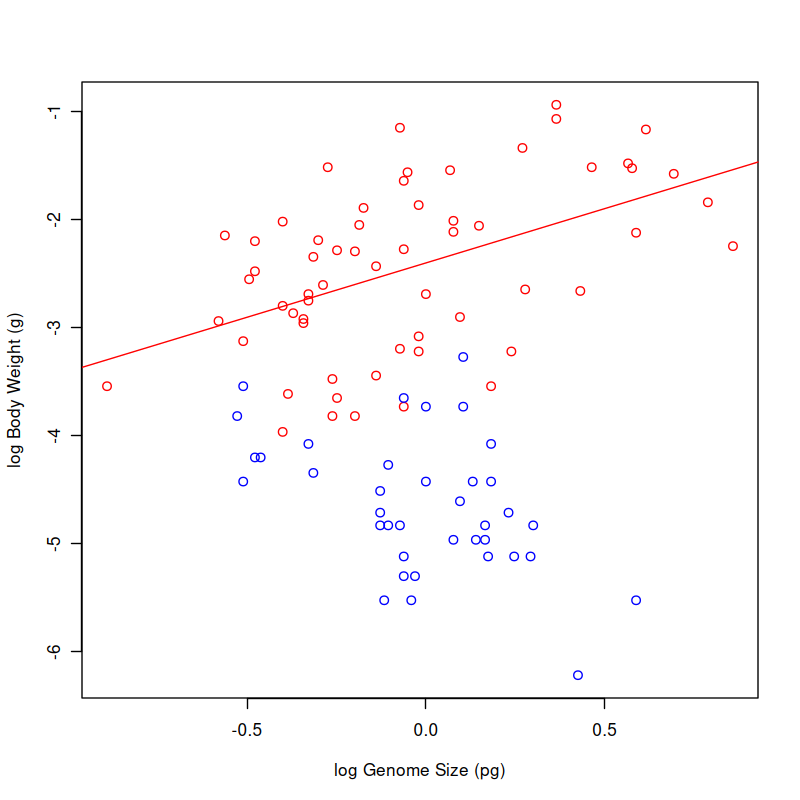

In [30]:
myCol <- c('red','blue')
library(repr); options(repr.plot.res = 100, repr.plot.width = 8, repr.plot.height = 8) # change plot size
plot(logBW ~ logGS, data=genome, col=myCol[Suborder], xlab='log Genome Size (pg)', ylab='log Body Weight (g)')

abline(genomeSizeModelDragon, col='red')

Your final figure should look something like this:

---
:::{figure-md} dragonfly-regression
<img src="./graphics/GenoRegModels.svg" alt="anova example" width="400px">

**Linear regression models fitted to the body weight vs. genome size to the Dragonfly (red) and Damselfly (blue) subsets of the data.**
:::

---


(regress:Diagnostics)=
## Model diagnostics

Now that we have our models, we need to check that they are appropriate for the data. For this, we will inspect "diagnostic plots". Producing diagnostic plots is easy in R — if you `plot` the model object, then r produces a set of diagnostic plots!

&starf; Try the following code (and include in the R script file):

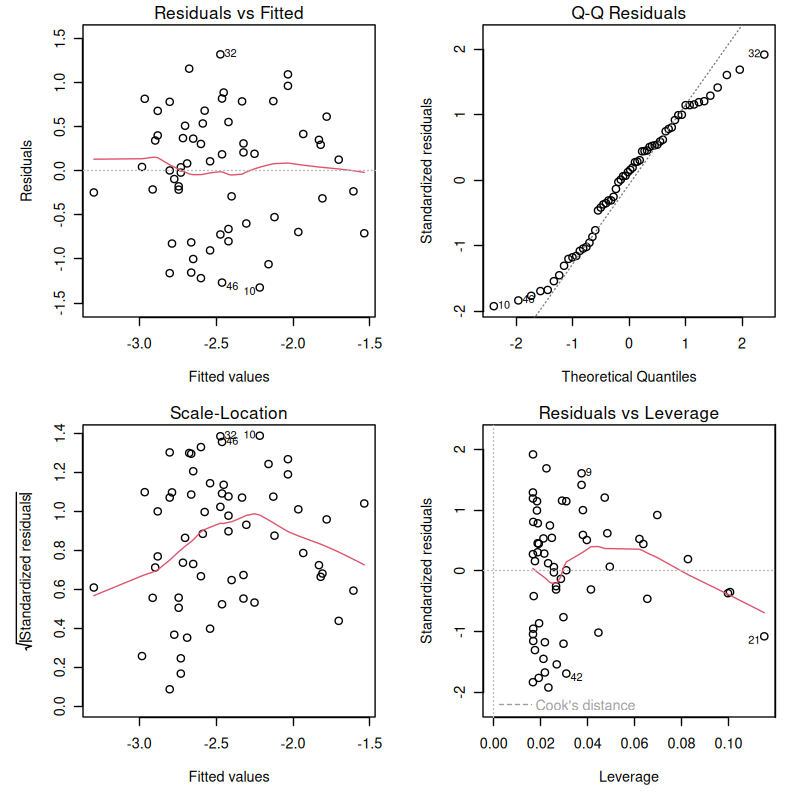

In [31]:
par(mfrow = c(2, 2), mar = c(5, 5, 1.5, 1.5))
plot(genomeSizeModelDragon)

These are the diagnostics for the `lm` fit to the Dragonfly data subset.

Let's also plot the diagnostic pots for the model fitted to the Damselfly subset:    

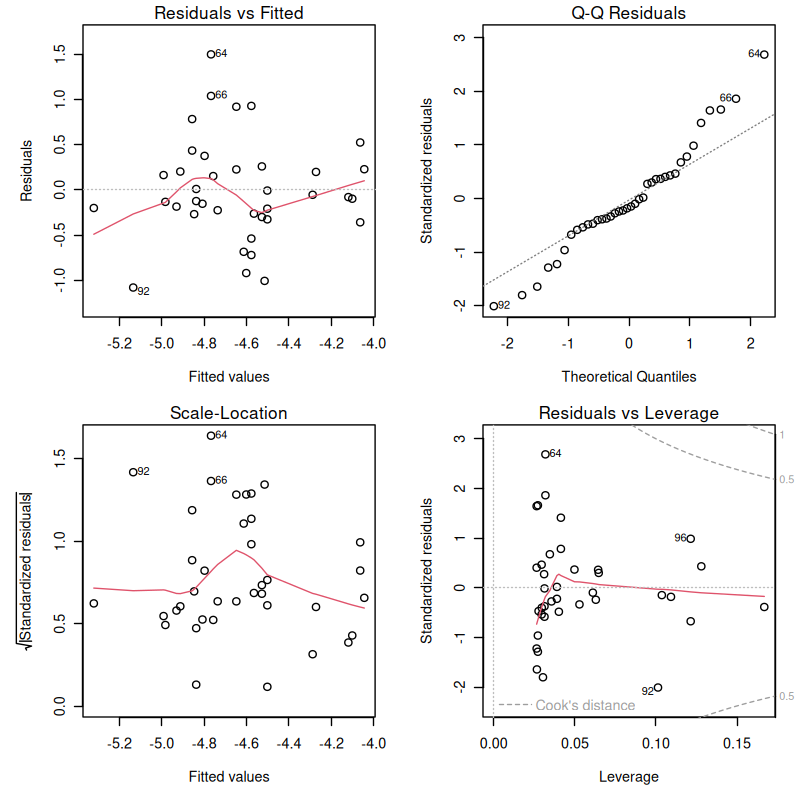

In [32]:
par(mfrow = c(2, 2), mar = c(5, 5, 1.5, 1.5))
plot(genomeSizeModelDamsel)

The diagnostic plots are:

* **residuals vs Fitted**: This plot is used to spot if the distribution of the residuals (the vertical distance from a point to the regression line) has *similar variance* for different predicted values (the y-value on the line corresponding to each x-value). There should be no obvious patterns (such as curves) or big gaps. If there was no scatter, if all the points fell exactly on the line, then all of the dots on this plot would lie on the gray horizontal dashed line. The red line is a smoothed curve to make it easier to see trends in the residuals. It is flat in the Dragonfly model fit above, and a bit more wavy than we would like in the in the Damselfly model fit, but there are no clear trends in either, which is what you hope to see.

* **Normal Q–Q**: This plot is to check whether the residuals are *normally distributed* — are the values of the observed residuals similar to those expected under a normal distribution? Ideally, the points should form a perfectly straight line, indicating that the observed residuals exactly match the expected. Here, note that the points lie pretty close to the dashed line in both sets of diagnostic Figures above, but deviate at the ends, especially for Damselflies. However, some deviation is to be expected near the ends — here these deviations are just about acceptable.

* **Scale–Location**: The x-axis on this plot is identical to the residuals vs Fitted plot – these are the fitted values. The y-axis is the square root of the *standardized residuals*, which are residuals rescaled so that they have a mean of zero and a variance of one. As a result, all y-axis values are positive. Thus large residuals (both positive and negative) plot at the top, and small residuals plot at the bottom (so only their *scale* is retained). Thus, all of the numbered points (which will be the same in all plots) plot at the top here. The red line here shows the trend, just like the residuals vs Fitted plot. The regression analysis has assumed homoscedasticity, that the variance in the residuals doesn't change as a function of the predictor. If that assumption is correct, the red line should be relatively flat. It is not quite as flat as we would like, especially for the Dragonfly analysis.

* **residuals vs Leverage**: This plot shows the standardized residuals against leverage. "Leverage" is a measure of how much each data point influences the linear model's coefficient estimates. Because the regression line must pass through the centroid ("pivot point") of the data, points that lie far from the centroid have greater leverage, and their leverage increases if there are fewer points nearby. Here is an illustration:

---
:::{figure-md} regress-leverage
<img src="./graphics/Leverage.svg" alt="Leverage" width="250px">

**Leverage of data points on slope of a regression.** The points further away from the centroid in the x-axis direction have more leverage, and can therefore move the regression line up or down (dashed red lines).
:::

---


There are two key things to note about the above plot:

1. The standardized residuals (y-axis) are centered around zero and reach 2-3 standard deviations away from zero. They should also lie symmetrically about zero, as would be expected for a normal distribution. This is the case for the Damselfly plot , but not so much for the Dragonfly plot.

2. The contours values show *Cook's distance* (only visible in the Damsefly plot), which measures how much the regression would change if a point was deleted. Cook's distance is increased by leverage and by large residuals: a point far from the centroid with a large residual can severely distort the coefficient estimates from the regression. On this plot, you want to see that the red smoothed line stays close to the horizontal gray dashed line and that no points have a large Cook's distance (i.e, &gt;0.5). Both are true here.

This is an important diagnostic plot in regression analyses in particular because it tells you whether your estimate of the slope coefficient in particular is strongly affected by certain data points.

Note that certain points are numbered in all the diagnostic plots — these are points to pay special attention to because they are *potential* outliers. The numbers correspond to the row number for that dataset in your data frame. You can easily identify these points in your data plot because the order of the points along the fitted values axis (y-axis) in the diagnostic plot matches the order along the x-axis in the data plot. So, for example here, in the dragonfly diagnostic plots the two numbered points (46, 10) near the bottom correspond in the data plot to the two red points near the center-left that lie farthest below the red line (see the plot with regression lines fitted to the data).

Thus, neither the Drangonfly nor the Damselfly diagnostic plots look perfect, but this level of deviation from assumptions of linear models is acceptable. The main worrying factors are that the Q-Q plot for Damselflies indicates the observed residuals are a bit more extreme than expected, and the Scale–Location plot for Dragonflies suggests some pattern in the standardized residuals wrt location of the fitted values.

&starf; Copy the code to create the diagnostic plots into your script to keep a
record of the code and run it.

## reporting the model

Now we know that the models are appropriate and we have a plot, the last thing is to report the statistics. For the damselfly model, here is one summary that would do: log genome size explains significant variation in log body weight in dameselflies (F=10.5, df=1,36, p=0.0025) and shows that body weight decreases with genome size (intercept: -4.65, se=0.09;
slope: -1.14, se=0.35).